In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


In [2]:
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


In [3]:
# df_1 = multiple_stock_data(ticker=[['GOOGL','AAPL','AMZN']], start='09-19-2015',end='09-19-2018',plot=True, stock_value='Adj Close')
# df_1

In [4]:
def single_stock_data(symbol, start,end,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Dataframe has 756 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-21,549.780029,539.590027,544.330017,548.390015,3283300,548.390015
2015-09-22,543.549988,532.659973,539.710022,538.400024,3841700,538.400024
2015-09-23,541.210022,534.000000,538.299988,536.070007,2237600,536.070007
2015-09-24,534.559998,522.869995,530.549988,533.750000,3501000,533.750000
2015-09-25,542.799988,521.400024,542.570007,524.250000,4031000,524.250000
...,...,...,...,...,...,...
2018-09-13,2008.760010,1982.030029,2000.000000,1989.869995,3621500,1989.869995
2018-09-14,1993.650024,1959.219971,1992.930054,1970.189941,3642000,1970.189941
2018-09-17,1956.819946,1887.410034,1954.729980,1908.030029,7050200,1908.030029


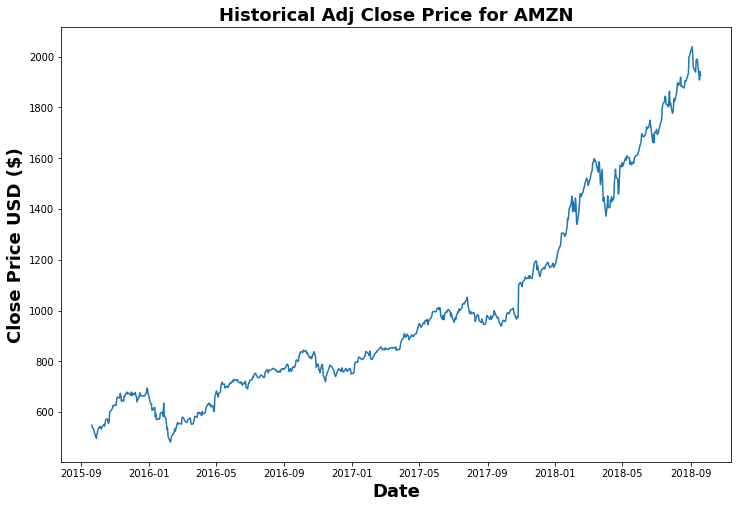

In [5]:
df = single_stock_data('AMZN', start='09-19-2015',end='09-19-2018',plot=True,stock_value='Adj Close')
df

In [6]:
df_1 = df['Adj Close']
df_data = pd.DataFrame(df_1)#.values.astype('float32')

In [7]:
df_data

,Adj Close
Date,
2015-09-21,548.390015
2015-09-22,538.400024
2015-09-23,536.070007
2015-09-24,533.750000
2015-09-25,524.250000
...,...
2018-09-13,1989.869995
2018-09-14,1970.189941
2018-09-17,1908.030029


In [8]:
# df_data = pd.read_csv('data/amzn.csv',usecols=[4]).values.astype('float32')
# df_data

In [9]:
def delta_time_series(data):
    data_1 = data.pct_change(1)
    #return data[1:]- data[:-1]
    data_1 = data_1.dropna()
    return data_1

In [10]:
dataset_delta_AMAZN = delta_time_series(df_data)
dataset_delta_AMAZN

,Adj Close
Date,
2015-09-22,-0.018217
2015-09-23,-0.004328
2015-09-24,-0.004328
2015-09-25,-0.017799
2015-09-28,-0.038512
...,...
2018-09-13,-0.000065
2018-09-14,-0.009890
2018-09-17,-0.031550


In [11]:
#df_data.shape

In [12]:
def plot_delta(data):
    plt.figure(figsize=(12,6))
    plt.plot(delta_time_series(data))
    plt.ylabel('close')
    plt.show()

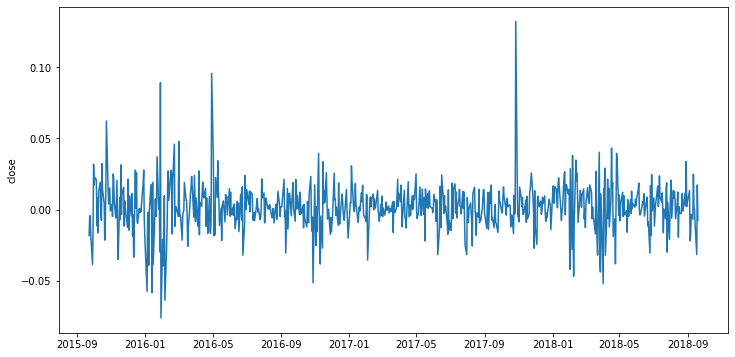

In [13]:
plot_delta(df_data)

In [14]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [15]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

In [16]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_delta_AMAZN)
# split into train and test sets
train_size = int(len(dataset) * 0.80)#0.67
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [17]:
train.shape, test.shape, 

((604, 1), (151, 1))

In [18]:
look_back = 3

In [19]:
train_data_gen = TimeseriesGenerator(train, train,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [20]:
test_data_gen = TimeseriesGenerator(test, test,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)

In [21]:
# model = Sequential()
# model.add(LSTM(4, input_shape=(look_back, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(look_back,1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [22]:
history = model.fit_generator(train_data_gen, epochs=100).history

Epoch 1/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0120
Epoch 2/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0072
Epoch 3/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 4/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0067
Epoch 5/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 6/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0067
Epoch 7/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0068
Epoch 8/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0067
Epoch 9/100
201/201 [==============================] - 2s 9ms/step - loss: 0.0067
Epoch 10/100
201/201 [==============================] - 2s 9ms/step - loss: 0.0066
Epoch 11/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0065
Epoch 12/100
201/201 [==============================] - 2s 8ms/step - loss: 0.0066
Epoch 13/100


201/201 [==============================] - 2s 9ms/step - loss: 0.0065
Epoch 100/100
201/201 [==============================] - 2s 9ms/step - loss: 0.0065


In [23]:
model.evaluate_generator(test_data_gen)

0.0011701465118676424

In [24]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(601, 1)

In [25]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(148, 1)

In [26]:
# invert predictions, scale values back to real index/price range.
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [27]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)


(601, 1)
(148, 1)


In [28]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(601, 1)
(148, 1)


In [29]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.38 RMSE
Test Score: 0.38 RMSE


In [30]:
dataset = scaler.inverse_transform(dataset)
dataset.shape

(755, 1)

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + df_data[1:]
# set empty values
# trainPredictPlot[0:look_back, :] = np.nan
# trainPredictPlot[len(trainPredict)+look_back:, :] = np.nan


In [32]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + df_data[1:]
# set empty values
# testPredictPlot[0:len(trainPredict)+(look_back*2), :] = np.nan
# testPredictPlot[len(dataset):, :] = np.nan

No handles with labels found to put in legend.


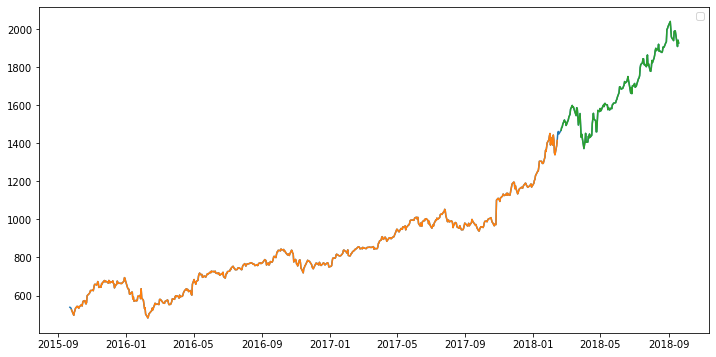

In [33]:
# plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(dataset + df_data[1:])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
#plt.show()


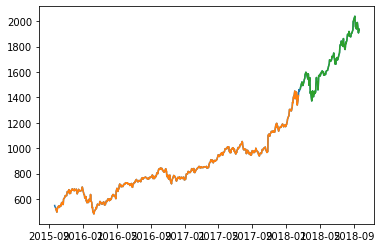

In [34]:
# plot baseline and predictions
plt.plot(dataset + df_data[:-1])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()